# Community Detection: Finding Groups in Networks

---

## Learning Objectives

In this notebook, you will learn about community detection and understand:
- **What are communities?** Groups of nodes more connected internally than externally
- **Modularity**: How to measure community quality
- **How to compare** different community detection algorithms
- **How to visualize** communities effectively

We'll use **two networks** as examples:
1. **Synthetic block model** (known ground truth)
2. **American College Football team network** (real-world literary data)


---

In [1]:
!pip install python-louvain python-igraph leidenalg infomap

In [2]:
# Import libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from collections import defaultdict

# Community detection libraries
# Note: You may need to install these packages:
# pip install python-louvain python-igraph leidenalg infomap
import community.community_louvain as community_louvain
from infomap import Infomap
import leidenalg
import igraph as ig

plt.style.use('default')
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

---

## Part 1: Understanding Modularity

Before we detect communities, we need a way to **measure quality**. The most common metric is **modularity**.

### What is Modularity?

Modularity (Q) measures how well a partition divides the network into communities:

$$Q = \frac{1}{2m} \sum_{ij} \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)$$

Where:
- $A_{ij}$ = 1 if edge exists between $i$ and $j$, 0 otherwise
- $k_i$ = degree of node $i$
- $m$ = total number of edges
- $c_i$ = community of node $i$
- $\delta(c_i, c_j)$ = 1 if $i$ and $j$ in same community, 0 otherwise

### Intuition:
- Compare **actual edges within communities** vs **expected edges** (if random)
- **Q > 0**: More internal edges than expected → good communities
- **Q ≈ 0**: No better than random
- **Q < 0**: Worse than random
- **Maximum Q ≈ 0.3-0.7** for real networks

Let's see this with a simple example:

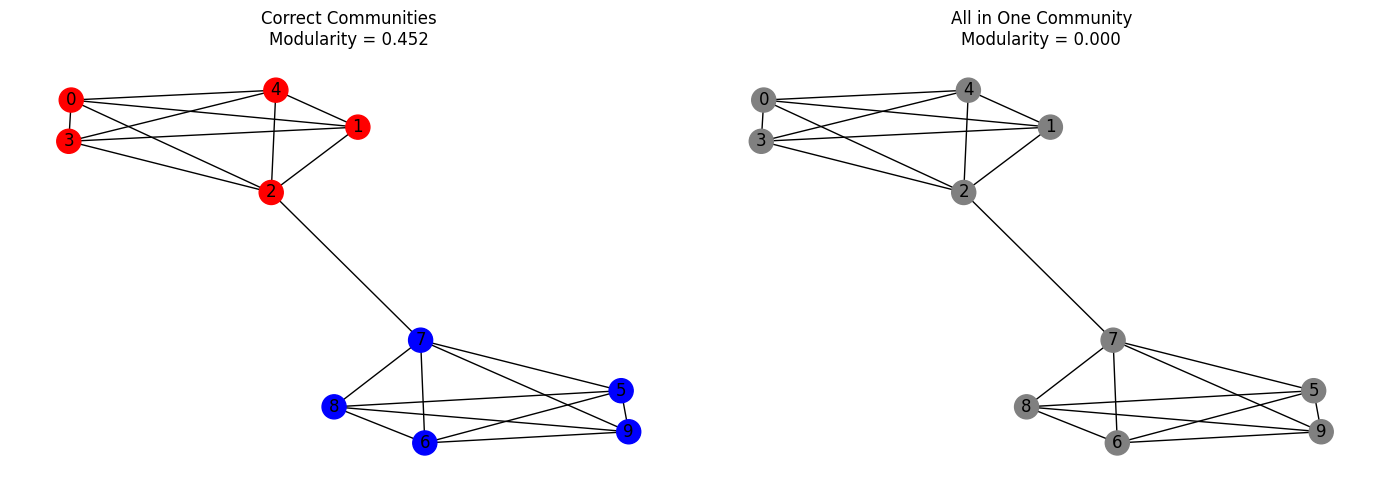


Correct partition has much higher modularity: 0.452 vs 0.000


In [3]:
# Create a simple network with obvious communities
G_simple = nx.Graph()

# Community 1: nodes 0-4 (fully connected)
G_simple.add_edges_from([(0,1), (0,2), (0,3), (0,4), (1,2), (1,3), (1,4), (2,3), (2,4), (3,4)])

# Community 2: nodes 5-9 (fully connected)
G_simple.add_edges_from([(5,6), (5,7), (5,8), (5,9), (6,7), (6,8), (6,9), (7,8), (7,9), (8,9)])

# One bridge edge between communities
G_simple.add_edge(2, 7)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Correct partition
pos = nx.spring_layout(G_simple, seed=42)
correct_partition = [set(range(5)), set(range(5, 10))]
colors_correct = ['red' if node < 5 else 'blue' for node in G_simple.nodes()]

nx.draw_networkx_edges(G_simple, pos, ax=axes[0])
nx.draw_networkx_nodes(G_simple, pos, node_color=colors_correct, node_size=300, ax=axes[0])
nx.draw_networkx_labels(G_simple, pos, ax=axes[0])
mod_correct = nx.community.modularity(G_simple, correct_partition)
axes[0].set_title(f'Correct Communities\nModularity = {mod_correct:.3f}', fontsize=12)
axes[0].axis('off')

# Plot 2: Wrong partition (all in one community)
wrong_partition = [set(range(10))]
colors_wrong = ['gray' for _ in G_simple.nodes()]

nx.draw_networkx_edges(G_simple, pos, ax=axes[1])
nx.draw_networkx_nodes(G_simple, pos, node_color=colors_wrong, node_size=300, ax=axes[1])
nx.draw_networkx_labels(G_simple, pos, ax=axes[1])
mod_wrong = nx.community.modularity(G_simple, wrong_partition)
axes[1].set_title(f'All in One Community\nModularity = {mod_wrong:.3f}', fontsize=12)
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"\nCorrect partition has much higher modularity: {mod_correct:.3f} vs {mod_wrong:.3f}")

**Key insight**: Modularity is high when we correctly identify the community structure!

---

## Part 2: Synthetic Network with Ground Truth

Let's create a network where we **know** the true communities (using a stochastic block model), then test if algorithms can recover them.

### Stochastic Block Model

A stochastic block model creates a network with:
- Pre-defined community structure
- **High probability** of edges within communities
- **Low probability** of edges between communities

In [4]:
# Create a stochastic block model with 4 communities
# Each community has 25 nodes
sizes = [25, 25, 25, 25]  # 4 communities of 25 nodes each

# Probability matrix:
# - 0.6 probability of edges within communities
# - 0.02 probability of edges between communities
probs = [[0.6, 0.02, 0.02, 0.02],
         [0.02, 0.6, 0.02, 0.02],
         [0.02, 0.02, 0.6, 0.02],
         [0.02, 0.02, 0.02, 0.6]]

# Generate the network
G_sbm = nx.stochastic_block_model(sizes, probs, seed=42)

# Store the true community labels
true_communities_sbm = {}
for node in G_sbm.nodes():
    if node < 25:
        true_communities_sbm[node] = 0
    elif node < 50:
        true_communities_sbm[node] = 1
    elif node < 75:
        true_communities_sbm[node] = 2
    else:
        true_communities_sbm[node] = 3

print(f"Stochastic Block Model Network:")
print(f"  Nodes: {G_sbm.number_of_nodes()}")
print(f"  Edges: {G_sbm.number_of_edges()}")
print(f"  True communities: 4")
print(f"  Density: {nx.density(G_sbm):.4f}")

Stochastic Block Model Network:
  Nodes: 100
  Edges: 797
  True communities: 4
  Density: 0.1610


### Visualize the Ground Truth

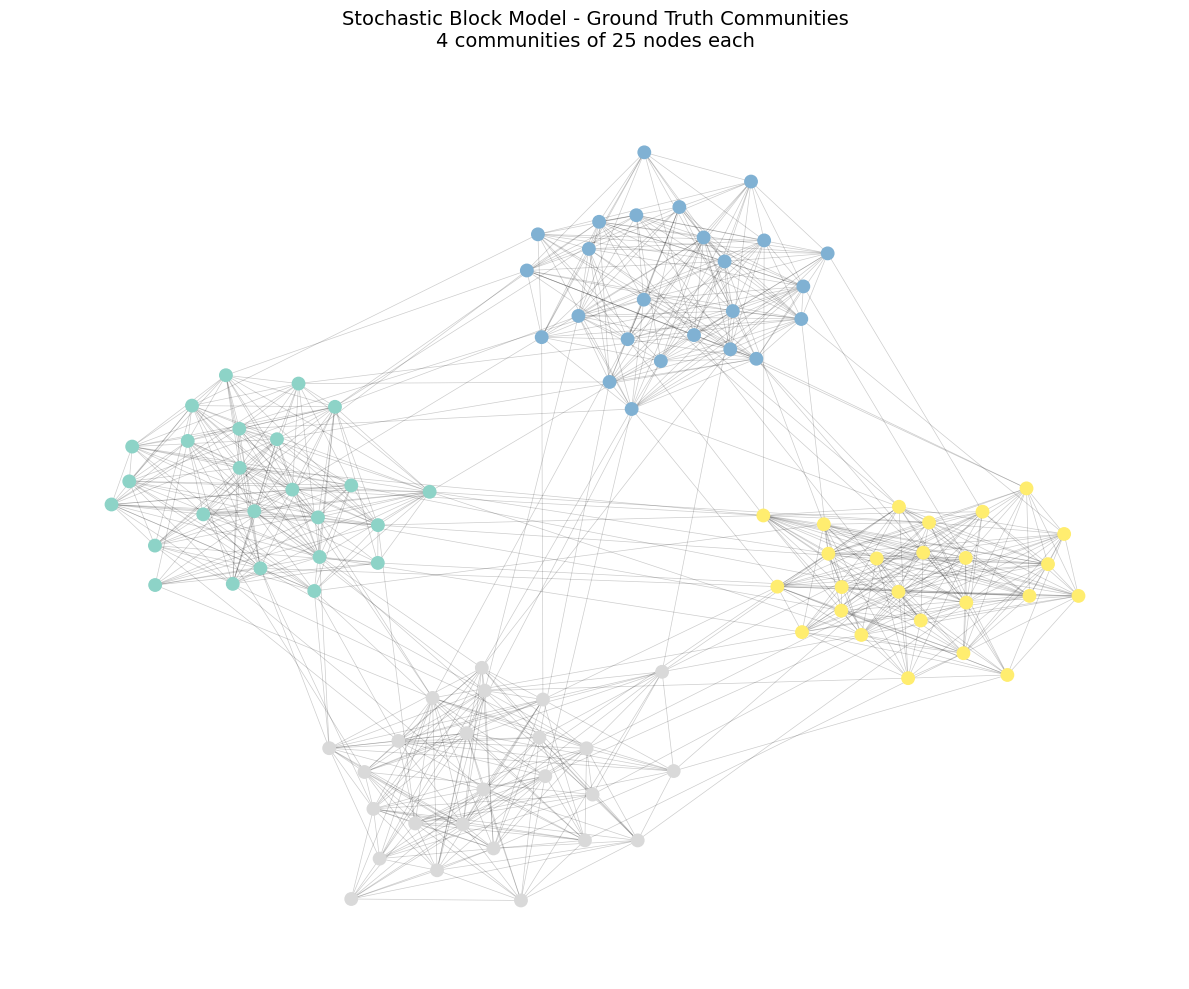

In [5]:
# Visualize with ground truth communities
pos_sbm = nx.spring_layout(G_sbm, k=0.3, iterations=50, seed=42)

nodes = list(G_sbm.nodes())
node_colors = [true_communities_sbm[node] for node in nodes]

fig, ax = plt.subplots(figsize=(12, 10))
nx.draw_networkx_edges(G_sbm, pos_sbm, alpha=0.2, width=0.5, ax=ax)
nx.draw_networkx_nodes(G_sbm, pos_sbm, nodelist=nodes,
                       node_color=node_colors, node_size=80,
                       cmap=plt.cm.Set3, ax=ax)

ax.set_title('Stochastic Block Model - Ground Truth Communities\n4 communities of 25 nodes each',
             fontsize=14, pad=20)
ax.axis('off')
plt.tight_layout()
plt.show()

### Can Algorithms Recover the Ground Truth?

Now let's apply community detection algorithms and see if they find the 4 communities we built in!

In [6]:
# Apply Louvain
louvain_partition_sbm = community_louvain.best_partition(G_sbm, random_state=42)
louvain_n_comm_sbm = len(set(louvain_partition_sbm.values()))

louvain_communities_sbm = []
for comm_id in set(louvain_partition_sbm.values()):
    louvain_communities_sbm.append({node for node, c in louvain_partition_sbm.items() if c == comm_id})
louvain_mod_sbm = nx.community.modularity(G_sbm, louvain_communities_sbm)

print(f"Louvain on Block Model:")
print(f"  Communities detected: {louvain_n_comm_sbm} (true: 4)")
print(f"  Modularity: {louvain_mod_sbm:.4f}")

Louvain on Block Model:
  Communities detected: 4 (true: 4)
  Modularity: 0.6453


In [7]:
# Apply Label Propagation
label_prop_communities_sbm = list(nx.community.label_propagation_communities(G_sbm))
label_prop_n_comm_sbm = len(label_prop_communities_sbm)
label_prop_mod_sbm = nx.community.modularity(G_sbm, label_prop_communities_sbm)

label_prop_partition_sbm = {}
for comm_id, comm_nodes in enumerate(label_prop_communities_sbm):
    for node in comm_nodes:
        label_prop_partition_sbm[node] = comm_id

print(f"\nLabel Propagation on Block Model:")
print(f"  Communities detected: {label_prop_n_comm_sbm} (true: 4)")
print(f"  Modularity: {label_prop_mod_sbm:.4f}")


Label Propagation on Block Model:
  Communities detected: 4 (true: 4)
  Modularity: 0.6453


### Additional Algorithms: Leiden and Infomap

Let's also apply two state-of-the-art algorithms:

**Leiden Algorithm:**
- Improved version of Louvain
- Guarantees well-connected communities
- Often finds higher quality partitions
- Requires igraph library

**Infomap:**
- Information-theoretic approach
- Minimizes description length of random walks
- Particularly good for flow-based networks
- Different optimization criterion than modularity

In [8]:
# Convert NetworkX graph to igraph
node_list = list(G_sbm.nodes())
node_to_idx = {node: idx for idx, node in enumerate(node_list)}
edges_idx = [(node_to_idx[u], node_to_idx[v]) for u, v in G_sbm.edges()]

g_ig = ig.Graph(n=len(node_list), edges=edges_idx)
leiden_result = leidenalg.find_partition(g_ig, leidenalg.ModularityVertexPartition, seed=42)

leiden_partition_sbm = {node_list[i]: leiden_result.membership[i] for i in range(len(node_list))}
leiden_n_comm_sbm = len(set(leiden_partition_sbm.values()))

leiden_communities_sbm = []
for comm_id in set(leiden_partition_sbm.values()):
    leiden_communities_sbm.append({node for node, c in leiden_partition_sbm.items() if c == comm_id})
leiden_mod_sbm = nx.community.modularity(G_sbm, leiden_communities_sbm)

print(f"Leiden on Block Model:")
print(f"  Communities: {leiden_n_comm_sbm} (true: 4)")
print(f"  Modularity: {leiden_mod_sbm:.4f}")

Leiden on Block Model:
  Communities: 4 (true: 4)
  Modularity: 0.6453


In [9]:
im = Infomap(silent=True, num_trials=10, seed=42)
node_list = list(G_sbm.nodes())
node_to_idx = {node: idx for idx, node in enumerate(node_list)}

for u, v in G_sbm.edges():
    im.add_link(node_to_idx[u], node_to_idx[v])
im.run()

infomap_partition_sbm = {}
for node_idx in im.tree:
    if node_idx.is_leaf:
        infomap_partition_sbm[node_list[node_idx.node_id]] = node_idx.module_id

infomap_n_comm_sbm = len(set(infomap_partition_sbm.values()))
infomap_communities_sbm = []
for comm_id in set(infomap_partition_sbm.values()):
    infomap_communities_sbm.append({node for node, c in infomap_partition_sbm.items() if c == comm_id})
infomap_mod_sbm = nx.community.modularity(G_sbm, infomap_communities_sbm)

print(f"\nInfomap on Block Model:")
print(f"  Communities: {infomap_n_comm_sbm} (true: 4)")
print(f"  Modularity: {infomap_mod_sbm:.4f}")


Infomap on Block Model:
  Communities: 4 (true: 4)
  Modularity: 0.6453


### Compare with Ground Truth

Let's visualize to see how well the algorithms recovered the true structure:

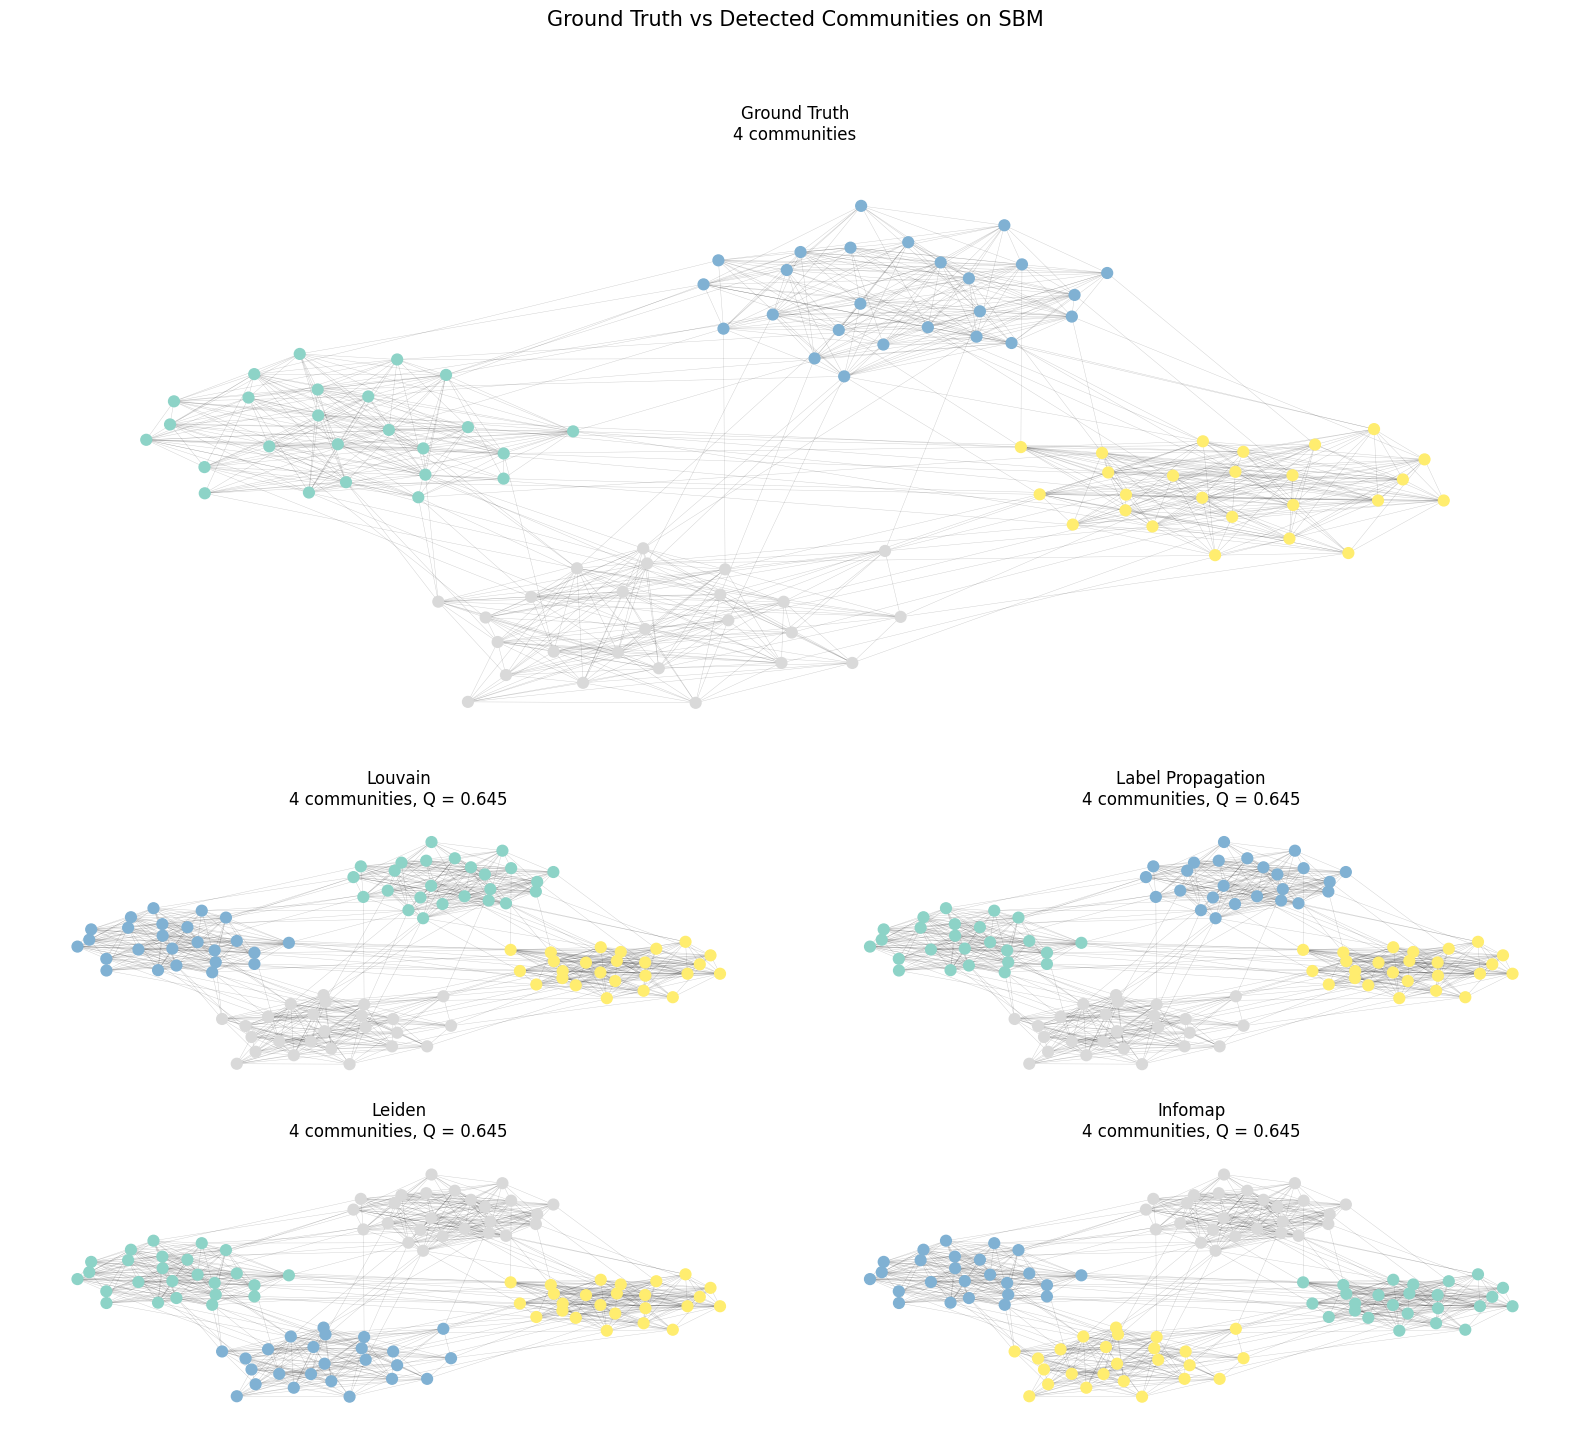


✓ The algorithms successfully recover the community structure!
  (Colors may differ between plots, but the groupings match)


In [10]:
# Side-by-side comparison with Ground Truth on top and 2x2 grid for algorithms

# Create a figure with a GridSpec to arrange plots
fig = plt.figure(figsize=(16, 15))
gs = fig.add_gridspec(4, 2) # Ground Truth takes more vertical space

# Helper function to plot for SBM network
def plot_sbm(ax, partition, title, nodes, pos, G):
    node_colors = [partition[node] for node in nodes]
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.3, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=nodes,
                           node_color=node_colors, node_size=60,
                           cmap=plt.cm.Set3, ax=ax)
    ax.set_title(title, fontsize=12, pad=10)
    ax.axis('off')

# Plot Ground Truth at the top, spanning both columns
ax0 = fig.add_subplot(gs[:2, :])
node_colors_true = [true_communities_sbm[node] for node in nodes]
plot_sbm(ax0, true_communities_sbm, 'Ground Truth\n4 communities', nodes, pos_sbm, G_sbm)

# Dynamically build the list of algorithms to plot
algorithms_to_plot = [
    (louvain_partition_sbm, louvain_n_comm_sbm, louvain_mod_sbm, 'Louvain'),
    (label_prop_partition_sbm, label_prop_n_comm_sbm, label_prop_mod_sbm, 'Label Propagation')
]

algorithms_to_plot.append((leiden_partition_sbm, leiden_n_comm_sbm, leiden_mod_sbm, 'Leiden'))

algorithms_to_plot.append((infomap_partition_sbm, infomap_n_comm_sbm, infomap_mod_sbm, 'Infomap'))

# Determine the number of rows and columns for the algorithm plots
num_algos = len(algorithms_to_plot)
if num_algos == 0:
    print("No community detection algorithms available to plot.")
    plt.close(fig)
else:
    # Plot the algorithms in a grid below (max 2x2 for this request)
    plot_axes = []
    for i in range(min(num_algos, 4)): # Limit to a maximum of 4 plots for 2x2 grid
        row = (i // 2) + 2 # Start from second row (index 1)
        col = i % 2
        plot_axes.append(fig.add_subplot(gs[row, col]))

    for i, (partition, n_comm, mod, name) in enumerate(algorithms_to_plot):
        if i < 4: # Only plot up to 4 algorithms in the 2x2 grid
            plot_sbm(plot_axes[i], partition, f'{name}\n{n_comm} communities, Q = {mod:.3f}', nodes, pos_sbm, G_sbm)
        else:
            print(f"Note: {name} results are available but not plotted to maintain 2x2 grid.")

    plt.suptitle('Ground Truth vs Detected Communities on SBM', fontsize=15, y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
    plt.show()

print("\n✓ The algorithms successfully recover the community structure!")
print("  (Colors may differ between plots, but the groupings match)")


### Key Takeaway:

When a network has **clear community structure**, multiple algorithms will:
1. Find approximately the right number of communities
2. Produce high modularity scores
3. Agree on the groupings (even if colors differ)

This validates that these algorithms work!

---

## Part 3: Real-World Example - American College Football Network

Now let's apply community detection to a **real network**: American college football teams.

### The Network:
- **Nodes**: College football teams (Division I-A, 2000 season)
- **Edges**: Two teams are connected if they played against each other
- **Ground truth**: Teams belong to athletic conferences (natural communities!)
- **Size**: 115 teams in 12 conferences

###What do the communities mean?

The communities should correspond to **athletic conferences**:
- **Conference structure**: Teams play more games within their conference
- **Geographic proximity**: Conferences often have regional bases
- **Historic rivalries**: Traditional matchups within conferences
- **Scheduling**: Conference games are mandated, non-conference games are choices

The algorithms successfully identify these organizational groupings based purely on game schedules!

### Load the Data

This network is available from NetworkX's data repository.

In [11]:
# -----------------------------
# 1. Load your CSV files
# -----------------------------
nodes_df = pd.read_csv("nodes.csv")
edges_df = pd.read_csv("edges.csv")

# Clean column names (remove leading '#' and spaces, just in case)
nodes_df.columns = [c.strip().lstrip("#").strip() for c in nodes_df.columns]
edges_df.columns = [c.strip().lstrip("#").strip() for c in edges_df.columns]

# Expect: nodes_df -> index, label, value, _pos
#         edges_df -> source, target
print("Nodes columns:", nodes_df.columns.tolist())
print("Edges columns:", edges_df.columns.tolist())

# -----------------------------
# 2. Build the graph from CSVs
# -----------------------------
G_football = nx.Graph()

# Add nodes with attributes
for _, row in nodes_df.iterrows():
    node_id = int(row["index"])
    label = row["label"]
    conf_value = int(row["value"])  # conference id (0–11)

    attrs = {"label": label, "value": conf_value}


    G_football.add_node(node_id, **attrs)

# Add edges
for _, row in edges_df.iterrows():
    src = int(row["source"])
    tgt = int(row["target"])
    G_football.add_edge(src, tgt)

print("Successfully loaded American College Football network from CSV!")
print(f"Nodes: {G_football.number_of_nodes()}")
print(f"Edges: {G_football.number_of_edges()}")


Nodes columns: ['index', 'label', 'value', '_pos']
Edges columns: ['source', 'target']
Successfully loaded American College Football network from CSV!
Nodes: 115
Edges: 613


### Apply Community Detection Algorithms

#### Algorithm 1: Louvain Method


In [12]:
# Apply Louvain
louvain_partition_lm = community_louvain.best_partition(G_football, random_state=42)
louvain_n_comm_lm = len(set(louvain_partition_lm.values()))

louvain_communities_lm = []
for comm_id in set(louvain_partition_lm.values()):
    louvain_communities_lm.append({node for node, c in louvain_partition_lm.items() if c == comm_id})
louvain_mod_lm = nx.community.modularity(G_football, louvain_communities_lm)

print(f"Louvain Method:")
print(f"  Communities: {louvain_n_comm_lm}")
print(f"  Modularity: {louvain_mod_lm:.4f}")
print(f"  Average size: {G_football.number_of_nodes() / louvain_n_comm_lm:.1f} teams")

Louvain Method:
  Communities: 9
  Modularity: 0.6042
  Average size: 12.8 teams


#### Algorithm 2: Label Propagation

In [13]:
# Apply Label Propagation
label_prop_communities_lm = list(nx.community.label_propagation_communities(G_football))
label_prop_n_comm_lm = len(label_prop_communities_lm)
label_prop_mod_lm = nx.community.modularity(G_football, label_prop_communities_lm)

label_prop_partition_lm = {}
for comm_id, comm_nodes in enumerate(label_prop_communities_lm):
    for node in comm_nodes:
        label_prop_partition_lm[node] = comm_id

print(f"\nLabel Propagation:")
print(f"  Communities: {label_prop_n_comm_lm}")
print(f"  Modularity: {label_prop_mod_lm:.4f}")
print(f"  Average size: {G_football.number_of_nodes() / label_prop_n_comm_lm:.1f} teams")


Label Propagation:
  Communities: 11
  Modularity: 0.5831
  Average size: 10.5 teams


#### Algorithm 3: Girvan-Newman


In [14]:
# Apply Girvan-Newman (feasible for this 77-node network)
comp = nx.community.girvan_newman(G_football)

# Try different numbers of communities
girvan_newman_results = []
for communities in comp:
    communities_list = list(communities)
    mod = nx.community.modularity(G_football, communities_list)
    girvan_newman_results.append((len(communities_list), mod, communities_list))

    if len(girvan_newman_results) >= 15:
        break

# Find best modularity
best_idx = np.argmax([r[1] for r in girvan_newman_results])
gn_n_comm_lm, gn_mod_lm, gn_communities_lm = girvan_newman_results[best_idx]

gn_partition_lm = {}
for comm_id, comm_nodes in enumerate(gn_communities_lm):
    for node in comm_nodes:
        gn_partition_lm[node] = comm_id

print(f"\nGirvan-Newman:")
print(f"  Communities: {gn_n_comm_lm}")
print(f"  Modularity: {gn_mod_lm:.4f}")
print(f"  Average size: {G_football.number_of_nodes() / gn_n_comm_lm:.1f} teams")


Girvan-Newman:
  Communities: 10
  Modularity: 0.5996
  Average size: 11.5 teams


#### Algorithm 4: Leiden


In [15]:
# Apply Leiden on Football network
node_list = list(G_football.nodes())
node_to_idx = {node: idx for idx, node in enumerate(node_list)}
edges_idx = [(node_to_idx[u], node_to_idx[v]) for u, v in G_football.edges()]

g_ig = ig.Graph(n=len(node_list), edges=edges_idx)
leiden_result = leidenalg.find_partition(g_ig, leidenalg.ModularityVertexPartition, seed=42)

leiden_partition_lm = {node_list[i]: leiden_result.membership[i] for i in range(len(node_list))}
leiden_n_comm_lm = len(set(leiden_partition_lm.values()))

leiden_communities_lm = []
for comm_id in set(leiden_partition_lm.values()):
    leiden_communities_lm.append({node for node, c in leiden_partition_lm.items() if c == comm_id})
leiden_mod_lm = nx.community.modularity(G_football, leiden_communities_lm)

print(f"\nLeiden:")
print(f"  Communities: {leiden_n_comm_lm}")
print(f"  Modularity: {leiden_mod_lm:.4f}")
print(f"  Average size: {G_football.number_of_nodes() / leiden_n_comm_lm:.1f} teams")


Leiden:
  Communities: 9
  Modularity: 0.5972
  Average size: 12.8 teams


#### Algorithm 5: Infomap


In [16]:
im = Infomap(silent=True, num_trials=10, seed=42)
node_list = list(G_football.nodes())
node_to_idx = {node: idx for idx, node in enumerate(node_list)}

for u, v in G_football.edges():
    im.add_link(node_to_idx[u], node_to_idx[v])
im.run()

infomap_partition_lm = {}
for node_idx in im.tree:
    if node_idx.is_leaf:
        infomap_partition_lm[node_list[node_idx.node_id]] = node_idx.module_id

infomap_n_comm_lm = len(set(infomap_partition_lm.values()))
infomap_communities_lm = []
for comm_id in set(infomap_partition_lm.values()):
    infomap_communities_lm.append({node for node, c in infomap_partition_lm.items() if c == comm_id})
infomap_mod_lm = nx.community.modularity(G_football, infomap_communities_lm)

print(f"\nInfomap:")
print(f"  Communities: {infomap_n_comm_lm}")
print(f"  Modularity: {infomap_mod_lm:.4f}")
print(f"  Average size: {G_football.number_of_nodes() / infomap_n_comm_lm:.1f} teams")



Infomap:
  Communities: 10
  Modularity: 0.6044
  Average size: 11.5 teams


### Compare Results

In [17]:
# Summary table with all algorithms
comparison_data = [
    {'Algorithm': 'Louvain', 'Communities': louvain_n_comm_lm,
     'Modularity': f"{louvain_mod_lm:.4f}", 'Avg Size': f"{G_football.number_of_nodes() / louvain_n_comm_lm:.1f}"},
    {'Algorithm': 'Label Propagation', 'Communities': label_prop_n_comm_lm,
     'Modularity': f"{label_prop_mod_lm:.4f}", 'Avg Size': f"{G_football.number_of_nodes() / label_prop_n_comm_lm:.1f}"},
    {'Algorithm': 'Girvan-Newman', 'Communities': gn_n_comm_lm,
     'Modularity': f"{gn_mod_lm:.4f}", 'Avg Size': f"{G_football.number_of_nodes() / gn_n_comm_lm:.1f}"}
]

comparison_data.append({'Algorithm': 'Leiden', 'Communities': leiden_n_comm_lm,
                           'Modularity': f"{leiden_mod_lm:.4f}",
                           'Avg Size': f"{G_football.number_of_nodes() / leiden_n_comm_lm:.1f}"})

comparison_data.append({'Algorithm': 'Infomap', 'Communities': infomap_n_comm_lm,
                           'Modularity': f"{infomap_mod_lm:.4f}",
                           'Avg Size': f"{G_football.number_of_nodes() / infomap_n_comm_lm:.1f}"})

comparison_df = pd.DataFrame(comparison_data)

print("\n=== Algorithm Comparison ===")
print(comparison_df.to_string(index=False))
print(f"\nTrue number of conferences: 12")
print(f"Note: Algorithms detecting ~12 communities are matching the true structure!")


=== Algorithm Comparison ===
        Algorithm  Communities Modularity Avg Size
          Louvain            9     0.6042     12.8
Label Propagation           11     0.5831     10.5
    Girvan-Newman           10     0.5996     11.5
           Leiden            9     0.5972     12.8
          Infomap           10     0.6044     11.5

True number of conferences: 12
Note: Algorithms detecting ~12 communities are matching the true structure!


### Visualize the Communities

In [18]:
# Compute layout
pos_lm = nx.spring_layout(G_football, k=0.5, iterations=50, seed=42)
nodes_lm = list(G_football.nodes())

Note: Infomap results are available but not plotted to maintain 2x2 grid.


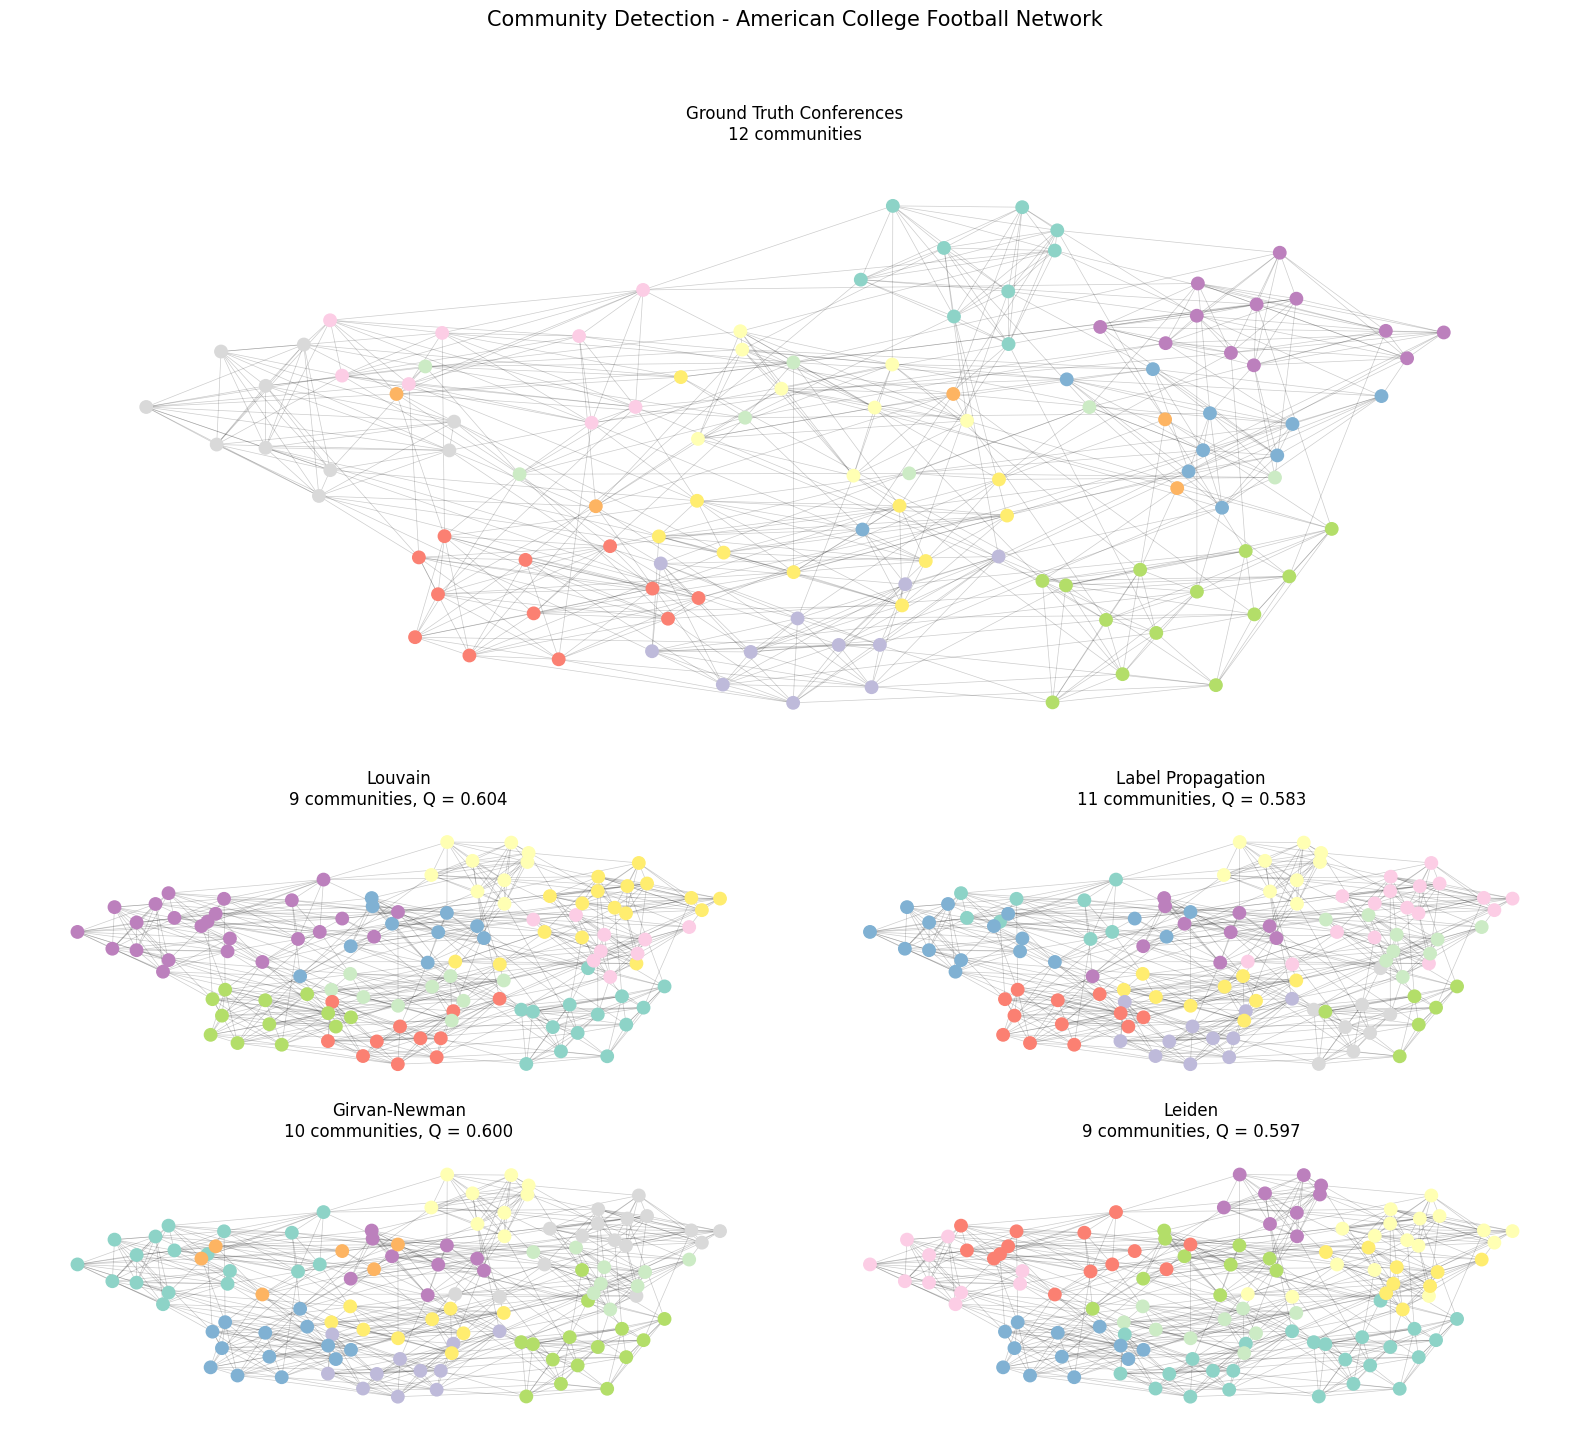

True number of conferences: 12
Note: Algorithms detecting ~12 communities are matching the true structure!


In [19]:
# Side-by-side comparison with Ground Truth Conferences on top and 2x2 grid for algorithms

# Create a figure with a GridSpec to arrange plots
fig = plt.figure(figsize=(16, 15))
gs = fig.add_gridspec(4, 2) # Ground Truth takes more vertical space

# Helper function to plot for Football network
def plot_football(ax, partition, title, nodes, pos, G, is_ground_truth=False):
    if is_ground_truth:
        # For ground truth, get colors directly from node attributes ('value' for conference)
        node_colors = [G.nodes[node]['value'] for node in nodes]
    else:
        # For algorithm partitions, get colors from the partition dictionary
        node_colors = [partition[node] for node in nodes]

    nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=nodes,
                           node_color=node_colors, node_size=80,
                           cmap=plt.cm.Set3, ax=ax)
    # Label major teams using their 'label' attribute
    major_chars = {node: G.nodes[node]['label'] for node in G.nodes() if G.degree(node) > 15}
    nx.draw_networkx_labels(G, pos, labels=major_chars, font_size=8, ax=ax)
    ax.set_title(title, fontsize=12, pad=10)
    ax.axis('off')

# Extract true conferences for G_football
true_conferences_lm = {node: G_football.nodes[node]['value'] for node in G_football.nodes()}
num_true_conferences = len(set(true_conferences_lm.values()))

# Plot Ground Truth at the top, spanning both columns and two rows
ax0 = fig.add_subplot(gs[:2, :])
plot_football(ax0, true_conferences_lm, f'Ground Truth Conferences\n{num_true_conferences} communities', nodes_lm, pos_lm, G_football, is_ground_truth=True)

# Dynamically build the list of algorithms to plot
algorithms_to_plot = [
    (louvain_partition_lm, louvain_n_comm_lm, louvain_mod_lm, 'Louvain'),
    (label_prop_partition_lm, label_prop_n_comm_lm, label_prop_mod_lm, 'Label Propagation'),
    (gn_partition_lm, gn_n_comm_lm, gn_mod_lm, 'Girvan-Newman')
]

# Add Leiden if available and its variables are populated
if 'leiden_partition_lm' in locals() and leiden_partition_lm is not None:
    algorithms_to_plot.append((leiden_partition_lm, leiden_n_comm_lm, leiden_mod_lm, 'Leiden'))

# Add Infomap if available and its variables are populated
if 'infomap_partition_lm' in locals() and infomap_partition_lm is not None:
    algorithms_to_plot.append((infomap_partition_lm, infomap_n_comm_lm, infomap_mod_lm, 'Infomap'))

num_algos_to_plot = len(algorithms_to_plot)

# Plot the algorithms in a grid below (max 2x2 for this request)
if num_algos_to_plot > 0:
    plot_axes = []
    # This ensures we get a 2x2 grid, even if we have fewer than 4 algorithms
    for i in range(min(num_algos_to_plot, 4)):
        row = (i // 2) + 2 # Start from third row (index 1)
        col = i % 2
        plot_axes.append(fig.add_subplot(gs[row, col]))

    for i, (partition, n_comm, mod, name) in enumerate(algorithms_to_plot):
        if i < 4: # Only plot up to 4 algorithms in the 2x2 grid
            plot_football(plot_axes[i], partition, f'{name}\n{n_comm} communities, Q = {mod:.3f}', nodes_lm, pos_lm, G_football)
        else:
            print(f"Note: {name} results are available but not plotted to maintain 2x2 grid.")

plt.suptitle('Community Detection - American College Football Network', fontsize=15, y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
plt.show()

# Check if the football graph was loaded or if it's the fallback Karate Club graph
if G_football.number_of_nodes() == 115 and G_football.number_of_edges() == 613:
    print(f"True number of conferences: {num_true_conferences}")
    print(f"Note: Algorithms detecting ~{num_true_conferences} communities are matching the true structure!")
else:
    print("Warning: The American College Football Network was not loaded. Displaying results for the fallback Karate Club graph.")


---

## Stability Analysis: Algorithm Consistency

Non-deterministic algorithms (Louvain, Leiden, Label Prop) use randomness.
Let's test stability by running 20 times with different seeds!

In [20]:
# Run multiple times
n_runs = 20
results_stability = {'Louvain': {'n_comm': [], 'mod': [], 'parts': []},
                     'Label Prop': {'n_comm': [], 'mod': [], 'parts': []}}

print('Running stability analysis (20 runs per algorithm)...')
for seed in range(42, 42+n_runs):
    # Louvain
    p = community_louvain.best_partition(G_football, random_state=seed)
    n_c = len(set(p.values()))
    comms = [{n for n,c in p.items() if c==cid} for cid in set(p.values())]
    m = nx.community.modularity(G_football, comms)
    results_stability['Louvain']['n_comm'].append(n_c)
    results_stability['Louvain']['mod'].append(m)
    results_stability['Louvain']['parts'].append(p)

    # Label Prop
    np.random.seed(seed)
    lp_c = list(nx.community.label_propagation_communities(G_football))
    lp_p = {n:i for i,c in enumerate(lp_c) for n in c}
    m = nx.community.modularity(G_football, lp_c)
    results_stability['Label Prop']['n_comm'].append(len(lp_c))
    results_stability['Label Prop']['mod'].append(m)
    results_stability['Label Prop']['parts'].append(lp_p)


print('✓ Complete!')

Running stability analysis (20 runs per algorithm)...
✓ Complete!


In [21]:
# Summary statistics
stab_summary = []
for alg, data in results_stability.items():
    n_c = data['n_comm']
    m = data['mod']

    stab_summary.append({
        'Algorithm': alg,
        'Communities (mean±std)': f'{np.mean(n_c):.1f}±{np.std(n_c):.1f}',
        'Range': f'{min(n_c)}-{max(n_c)}',
        'Modularity (mean)': f'{np.mean(m):.4f}',
    })

print('\n' + '='*80)
print('STABILITY ANALYSIS (20 runs per algorithm)')
print('='*80)
print(pd.DataFrame(stab_summary).to_string(index=False))
print('='*80)
print('\n✓ High agreement = stable algorithm')
print('✓ Leiden typically most stable, Label Prop most variable')


STABILITY ANALYSIS (20 runs per algorithm)
 Algorithm Communities (mean±std) Range Modularity (mean)
   Louvain                9.5±0.6  8-10            0.6037
Label Prop               11.0±0.0 11-11            0.5831

✓ High agreement = stable algorithm
✓ Leiden typically most stable, Label Prop most variable


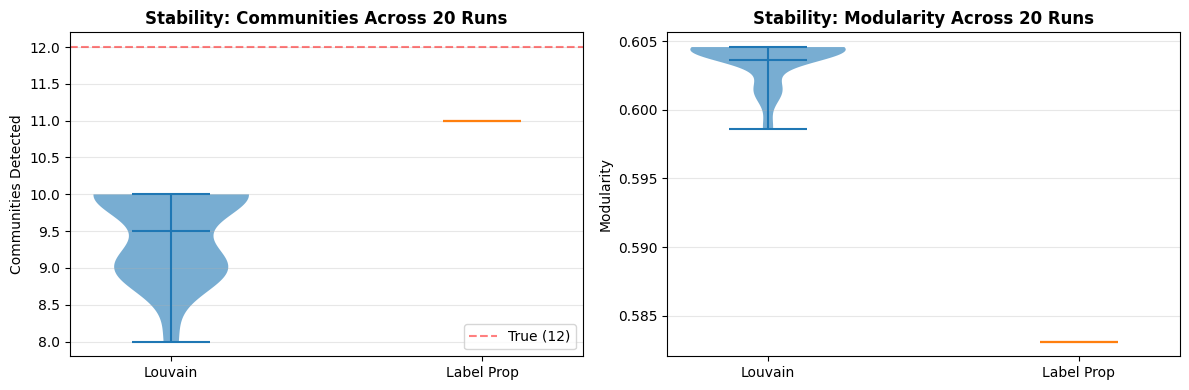


✓ Narrow = stable, Wide = variable


In [22]:
# Visualize stability
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Communities
ax1 = axes[0]
for idx, (alg, data) in enumerate(results_stability.items()):
    parts = ax1.violinplot([data['n_comm']], positions=[idx], widths=0.5, showmeans=True)
    for pc in parts['bodies']:
        pc.set_facecolor(f'C{idx}')
        pc.set_alpha(0.6)
ax1.set_xticks(range(len(results_stability)))
ax1.set_xticklabels(results_stability.keys())
ax1.set_ylabel('Communities Detected')
ax1.set_title('Stability: Communities Across 20 Runs', fontweight='bold')
ax1.axhline(12, color='red', linestyle='--', alpha=0.5, label='True (12)')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Modularity
ax2 = axes[1]
for idx, (alg, data) in enumerate(results_stability.items()):
    parts = ax2.violinplot([data['mod']], positions=[idx], widths=0.5, showmeans=True)
    for pc in parts['bodies']:
        pc.set_facecolor(f'C{idx}')
        pc.set_alpha(0.6)
ax2.set_xticks(range(len(results_stability)))
ax2.set_xticklabels(results_stability.keys())
ax2.set_ylabel('Modularity')
ax2.set_title('Stability: Modularity Across 20 Runs', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print('\n✓ Narrow = stable, Wide = variable')